# FML Exercise 1: Evaluation of the Nearest Neighbor Method

In [1]:
import numpy as np
import sklearn.decomposition as decomp
import matplotlib.pyplot as plt

## Prepare data

In [2]:
data = np.char.encode(np.loadtxt("digits.txt", dtype=str), "ascii") # Read data as array of ASCII strings
data = (data.view("S1") == b'1').astype(np.int8).reshape((-1, 32, 32)) # Convert strings into 8-bit integer arrays
y = np.repeat(np.array([0,1,8]).reshape((-1,1)), 50, axis=-1).reshape(-1) # Array of 50 "0", 50 "1"s and 50 "8"s

## Plot data

We begin by plotting three sample images from the dataset.

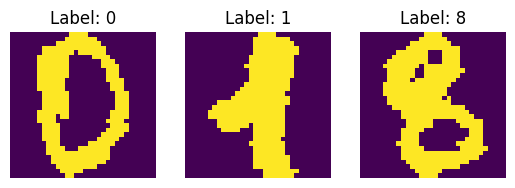

In [3]:
def plot_images(data, ys):
  fig, axs = plt.subplots(ncols=len(data), nrows=1)
  for i, (img, y) in enumerate(zip(data, ys)):
    ax = axs[i]
    ax.imshow(img)
    ax.axis("off")
    ax.title.set_text(f"Label: {y}")
    
  plt.show()

sample_idxs = [0,50,100]
plot_images(data[sample_idxs], y[sample_idxs])

## (a) NN with LOO-CV

**Tip 1:**
Note that NN has similarities to the $k$-means clustering algorithm, so you can adapt the implementation from the intro exercise.

**Tip 2:**
Since the features of the images are binary (a pixel is either black or white), you can use the so-called [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance), instead of the Euclidean distance for this exercise.
The advantage of using the Hamming distance instead of the Euclidean distance is that it is cheaper to compute.

In [4]:
# TODO

## (b) NN with LOO-CV using High-level Feature Embeddings

In [5]:
# TODO

## (c) Scatter plots of the image embeddings

**Tip:** Take a look at the [`scatter`](https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html) method in matplotlib.

In [6]:
# TODO